## Import Packages


In [2]:
# This cell will throw an error the first time. Run it once more to fix it.
import numpy as np
import os
import pandas as pd
import random
import math

os.environ["KERAS_BACKEND"] = "tensorflow"
from sklearn.model_selection import train_test_split

!pip install -q tensorflow
!pip install -q tensorflow-model-optimization
import tensorflow as tf
from tensorflow_model_optimization.python.core.keras.compat import keras

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

from sklearn.metrics import balanced_accuracy_score

import gzip
import tempfile
import zipfile
import matplotlib.pyplot as plt

## Mount Drive & Load Data

In [3]:
#mount drive
from google.colab import drive

drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/CS528_Final_Project/data/track_2'

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1xvlcJwYB3Kz9p5Ujs3uGbul5qqtgXQYV/CS528_Final_Project/data/track_2


In [4]:
# Load datasets

# Original Dataset
train_imgs = np.load('train_dataset_initial_cleaned.npz')['X_data']
train_labels = np.load('train_dataset_initial_cleaned.npz')['Y_data']

val_imgs = np.load('val_dataset_initial_cleaned.npz')['X_data']
val_labels = np.load('val_dataset_initial_cleaned.npz')['Y_data']

test_imgs = np.load('test_dataset_initial.npz')['X_data']
test_labels = np.load('test_dataset_initial.npz')['Y_data']

# Another training dataset collected at a separate time
train_imgs2 = np.load('train_rc_dataset2.npz')['X_data']
train_labels2 = np.load('train_rc_dataset2.npz')['Y_data']

val_imgs2 = np.load('val_rc_dataset2.npz')['X_data']
val_labels2 = np.load('val_rc_dataset2.npz')['Y_data']

test_imgs2 = np.load('test_rc_dataset2.npz')['X_data']
test_labels2 = np.load('test_rc_dataset2.npz')['Y_data']

# DAgger Data
N_DAGGER_ITERS = 1
dagger_imgs = []
dagger_labels = []

for i in range(1, N_DAGGER_ITERS + 1):
  dagger_imgs.append(np.load('train_dagger2_iter_' + str(i) + '.npz')['X_data'])
  dagger_labels.append(np.load('train_dagger2_iter_' + str(i) + '.npz')['Y_data'])


## Dataset Info

In [5]:
# Shape
print("Original Train images shape:", train_imgs.shape)
print("Original Train Labels shape:", train_labels.shape)
print()
print("Original Val images shape:", val_imgs.shape)
print("Original Val labels shape:", val_labels.shape)
print()
print("Original Test images shape:", test_imgs.shape)
print("Original Test labels shape:", test_labels.shape)
print()
print("Second Train images shape:", train_imgs2.shape)
print("Second Train labels shape:", train_labels2.shape)
print()
print("Second Val images shape:", val_imgs2.shape)
print("Second Val labels shape:", val_labels2.shape)
print()
print("Second Test images shape:", test_imgs2.shape)
print("Second Test labels shape:", test_labels2.shape)
print()
print("Newest Dagger Shape: ", dagger_imgs[-1].shape)

Original Train images shape: (57545, 60, 80, 3)
Original Train Labels shape: (57545, 22)

Original Val images shape: (14028, 60, 80, 3)
Original Val labels shape: (14028, 22)

Original Test images shape: (13646, 60, 80, 3)
Original Test labels shape: (13646, 22)

Second Train images shape: (15842, 60, 80, 3)
Second Train labels shape: (15842, 22)

Second Val images shape: (1928, 60, 80, 3)
Second Val labels shape: (1928, 22)

Second Test images shape: (1822, 60, 80, 3)
Second Test labels shape: (1822, 22)

Newest Dagger Shape:  (5002, 60, 80, 3)


## Combine Datasets

In [6]:
def take_n_percent(X, y, n):
    n = int(len(X) * n)
    idx = np.random.choice(len(X), size=n, replace=False)
    return X[idx], y[idx]

# Undersample original training dataset
train_imgs_20, train_labels_20 = take_n_percent(train_imgs, train_labels, 0.5)
val_imgs_20, val_labels_20   = take_n_percent(val_imgs, val_labels,  0.5)
test_imgs_20, test_labels_20 = take_n_percent(test_imgs, test_labels, 0.5)

# Concatenate both training datasets
X_train = np.concatenate([train_imgs_20, train_imgs2], axis=0)
y_train = np.concatenate([train_labels_20, train_labels2], axis=0)

X_val = np.concatenate([val_imgs_20, val_imgs2], axis=0)
y_val = np.concatenate([val_labels_20, val_labels2], axis=0)

X_test = np.concatenate([test_imgs_20, test_imgs2], axis=0)
y_test = np.concatenate([test_labels_20, test_labels2], axis=0)

# Shuffle Everything Up
def shuffle(X, y):
    perm = np.random.permutation(len(X))
    return X[perm], y[perm]

train_imgs, train_labels = shuffle(X_train, y_train)
val_imgs, val_labels    = shuffle(X_val, y_val)
test_imgs, test_labels   = shuffle(X_test, y_test)

In [7]:
# Add DAgger Data to Training

all_dagger = np.concatenate(dagger_imgs, axis=0)
all_dagger_labels = np.concatenate(dagger_labels, axis=0)

train_imgs = np.concatenate([train_imgs, all_dagger], axis=0)
train_labels = np.concatenate([train_labels, all_dagger_labels], axis=0)

# Shuffle
perm = np.random.permutation(len(train_imgs))
train_imgs = train_imgs[perm]
train_labels = train_labels[perm]

print("Total: ", train_imgs.shape)

Total:  (49616, 60, 80, 3)


## Data Augmentation

Horizontal Flip of Images (Also flips steering labels)

In [1]:
FLIP_AUGMENTATION = False

if FLIP_AUGMENTATION:
  steering_col = train_labels[:, -1]
  indices = np.where((steering_col == -1) | (steering_col == 1))[0]

  train_imgs_steering_only = train_imgs[indices].copy()
  train_labels_steering_only = train_labels[indices].copy()

  train_imgs_flipped = tf.image.flip_left_right(train_imgs_steering_only)

  # Flip steering values
  train_labels_steering_only[:, -1] = train_labels_steering_only[:, -1] * -1

  # Append to flipped data to original data
  train_imgs = np.concatenate([train_imgs, train_imgs_flipped], axis=0)
  train_labels = np.concatenate([train_labels, train_labels_steering_only], axis=0)
else:
  print("Flip Augmentation is Turned Off")

Flip Augmentation is Turned Off


In [8]:
# A selection of augmentation techniques (must be added to augment_image pipeline to take effect)
rotation = keras.layers.RandomRotation(0.01)
translation = keras.layers.RandomTranslation(0.05, 0.05)
zoom = keras.layers.RandomZoom(0.01)
brightness = keras.layers.RandomBrightness(0.0015)
noise = keras.layers.GaussianNoise(0.015)

def augment_image(img):
    img = brightness(img, training=True)
    return img

# Apply to dataset
augmented_train_imgs = augment_image(train_imgs)

### Vizualize Augmentation

Top row are original images. Bottom row is after augmentation

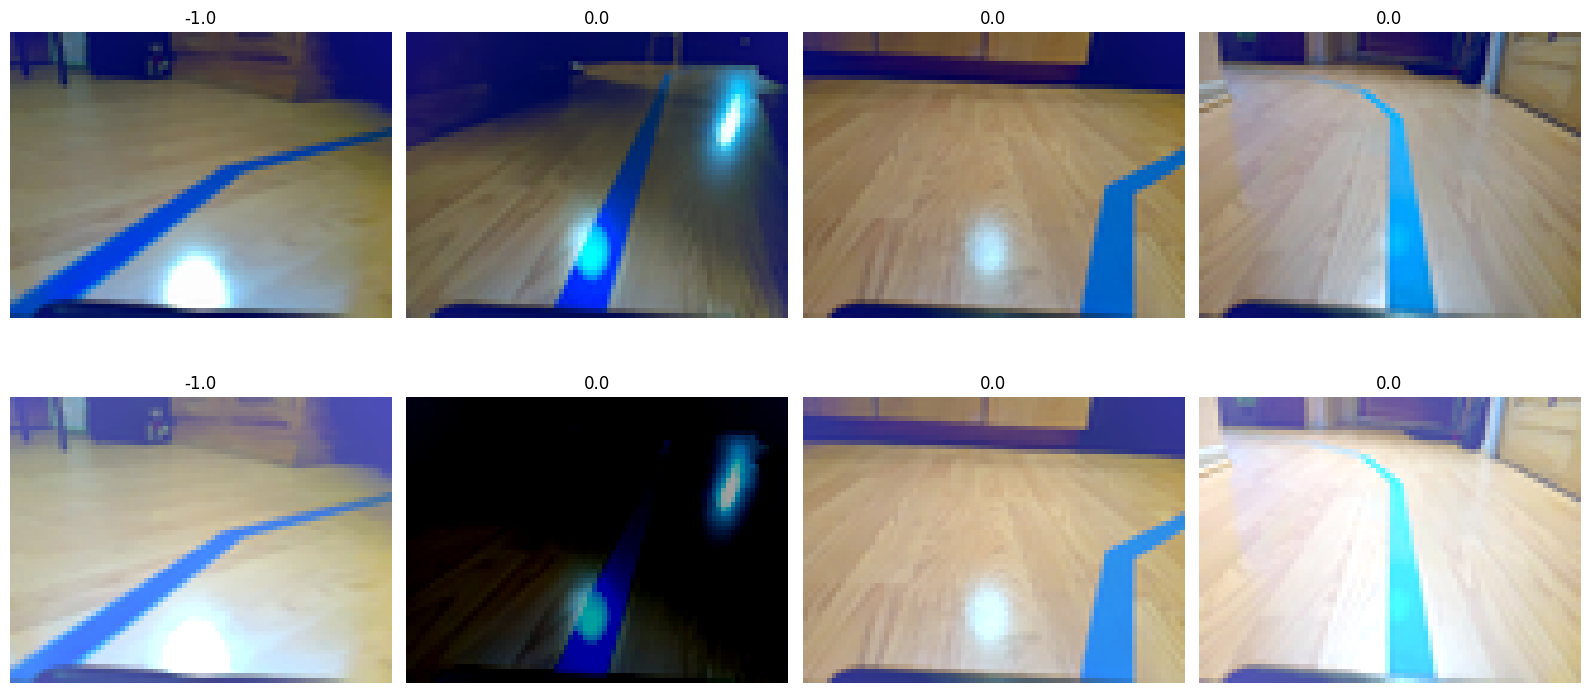

In [9]:
plt.figure(figsize=(16, 8))

indices = [random.randint(0, len(train_imgs) - 1) for _ in range(4)]

# Top row: original images
for i, idx in enumerate(indices):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(train_imgs[idx])
    plt.title(train_labels[idx][-1])
    plt.axis("off")

# Bottom row: augmented images (same indices)
for i, idx in enumerate(indices):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(augmented_train_imgs[idx])
    plt.title(train_labels[idx][-1])
    plt.axis("off")

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Distribution of Steering Commands (DAgger)')

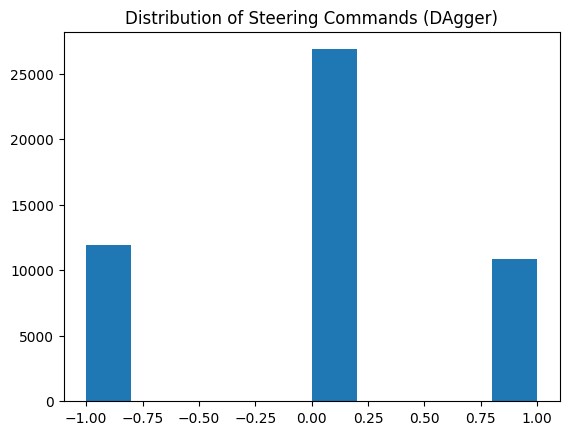

In [10]:
import matplotlib.pyplot as plt

plt.hist(train_labels[:,-1])
plt.title("Distribution of Steering Commands")

## Preprocess Metadata

We experimented with including various metadata along with images in our model. This included past steering history, as well as information on the current throttle of the car. We found this metadata not to help, so we stopped using it in our models.


In [11]:
# First value is timestep, then the next 20 values are previous steering commands from the last 2 seconds (taken at 0.1s intervals)
# Following this is the index within the throttle pulse cycle it is. (Throttle is on for 15 then off for 45 iterations so idx captures where in the 60 iteration cycle it is)
# Finally is the expert steering command

train_metadata = train_labels[:,:-1]
val_metadata = val_labels[:,:-1]
test_metadata = test_labels[:,:-1]

# Change Steering angles from range [-1, 1] to [0,2]
Y_train = train_labels[:,-1] + 1
Y_val =  val_labels[:,-1] + 1
Y_test = test_labels[:,-1] + 1

# Do the same for the steering lookback
train_metadata[:,0: -1] +=1
test_metadata[:,0:-1] +=1
val_metadata[:,0:-1] +=1

# Normalize Throttle Pulse Index
train_metadata[:,-1] /= 59
test_metadata[:,-1] /= 59
val_metadata[:,-1] /= 59

## Train Model

In [ ]:
image_input = keras.Input(shape=(60, 80, 3))


x = keras.layers.Conv2D(24, 5, padding='same', use_bias=False)(image_input)
x = keras.layers.BatchNormalization(center=True, scale=False)(x)
x = keras.layers.Activation('relu')(x)


x = keras.layers.Conv2D(36, 5, strides=2, padding='same', use_bias=False)(x)
x = keras.layers.BatchNormalization(center=True, scale=False)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Conv2D(48, 3, strides=2, padding='same', use_bias=False)(x)
x = keras.layers.BatchNormalization(center=True, scale=False)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Conv2D(48, 7, strides=7, padding='same', use_bias=False)(x)
x = keras.layers.BatchNormalization(center=True, scale=False)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(64)(x)
x = keras.layers.BatchNormalization(center=True, scale=False)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(24)(x)
x = keras.layers.BatchNormalization(center=True, scale=False)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.2)(x)

output = keras.layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs=[image_input], outputs=output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 80, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 80, 24)        1800      
                                                                 
 batch_normalization (Batch  (None, 60, 80, 24)        72        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 60, 80, 24)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 40, 36)        21600     
                                                                 
 batch_normalization_1 (Bat  (None, 30, 40, 36)        108       
 chNormalization)                                            

In [14]:
# Class weights can be used to emphasize under-represented classes
class_weight = {
    0: 1.4,
    1: 1.0,
    2: 1.0
}

def lr_decay(epoch):
    return 0.04 * math.pow(0.93, epoch)

lr_decay_callback = keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

history = model.fit(
    [augmented_train_imgs],
    Y_train,
    epochs=30,
    batch_size=32,
    validation_data=([val_imgs], Y_val),
    class_weight=class_weight,
    callbacks=[lr_decay_callback, early_stop]
)



Epoch 1: LearningRateScheduler setting learning rate to 0.04.
Epoch 1/30
1551/1551 [==============================] - 19s 8ms/step - loss: 0.7259 - accuracy: 0.7336 - val_loss: 0.4278 - val_accuracy: 0.8148 - lr: 0.0400

Epoch 2: LearningRateScheduler setting learning rate to 0.037200000000000004.
Epoch 2/30
1551/1551 [==============================] - 11s 7ms/step - loss: 0.6554 - accuracy: 0.7640 - val_loss: 0.5070 - val_accuracy: 0.8026 - lr: 0.0372

Epoch 3: LearningRateScheduler setting learning rate to 0.03459600000000001.
Epoch 3/30
1551/1551 [==============================] - 11s 7ms/step - loss: 0.6281 - accuracy: 0.7728 - val_loss: 0.4193 - val_accuracy: 0.8343 - lr: 0.0346

Epoch 4: LearningRateScheduler setting learning rate to 0.032174280000000006.
Epoch 4/30
1551/1551 [==============================] - 12s 7ms/step - loss: 0.6029 - accuracy: 0.7803 - val_loss: 0.3679 - val_accuracy: 0.8478 - lr: 0.0322

Epoch 5: LearningRateScheduler setting learning rate to 0.0299220804

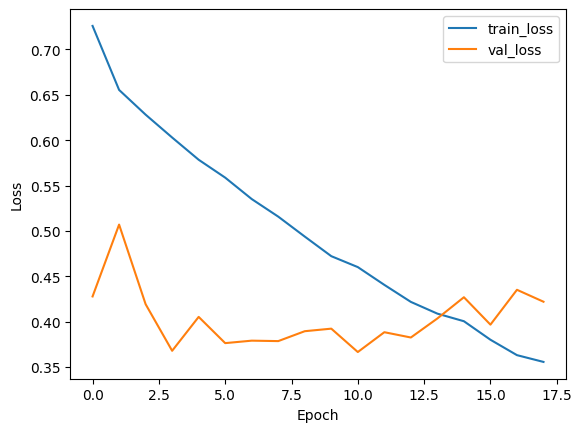

In [15]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

As you can see, the model starts to overfit after about 10 epochs. We use early stopping with restore best weights to get the model which performs best on the validation set.

## Evaluate Model

In [17]:
accuracy = model.evaluate([test_imgs],  Y_test)
print("Model Accuracy: {:.4f}".format(accuracy[1]))

271/271 [==============================] - 1s 3ms/step - loss: 0.3788 - accuracy: 0.8434
Model Accuracy: 0.8434


In [18]:
y_pred = np.argmax(model.predict([test_imgs]), axis=1)
balanced_acc = balanced_accuracy_score(Y_test, y_pred)

print("Balanced Accuracy: ", balanced_acc)

271/271 [==============================] - 1s 2ms/step
Balanced Accuracy:  0.7914099856384348


## Save Model

In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/CS528_Final_Project/model/006/"
file_path = os.path.join(MODEL_SAVE_PATH, "model2.keras")
model.save(file_path)

## Vizualize Some Model Predictions

271/271 [==============================] - 1s 2ms/step


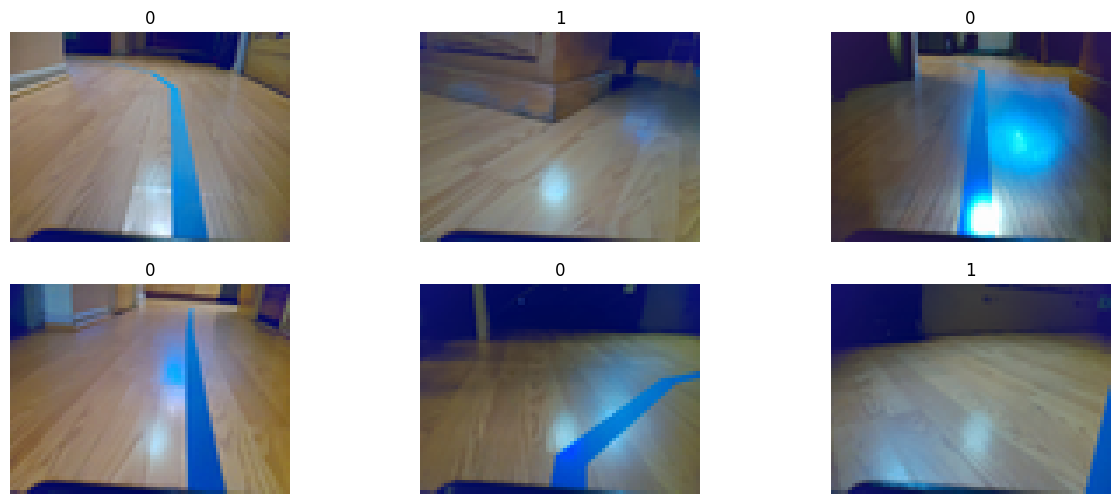

In [21]:
predictions = model.predict([test_imgs])
plt.figure(figsize=(15, 6))

for i in range(6):
  random_index = random.randint(0, len(test_imgs) - 1)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(test_imgs[random_index])

  # Throttle, steering direction
  plt.title(np.argmax(predictions[random_index])-1)
  plt.axis("off")

plt.show()

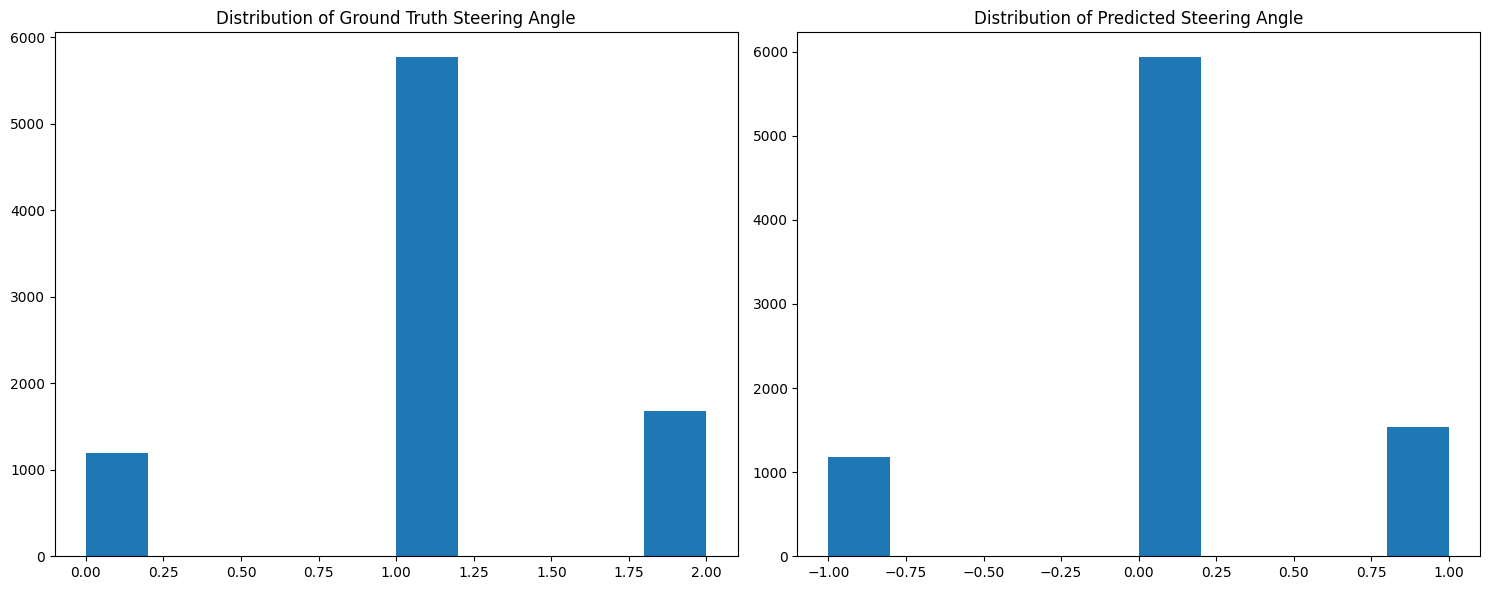

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax2.hist(np.argmax(predictions, axis=1)-1)
ax2.set_title("Distribution of Predicted Steering Angle")
ax1.hist(Y_test)
ax1.set_title("Distribution of Ground Truth Steering Angle")

plt.tight_layout()
plt.show()

## Prune and Quantize

### Pruning

In [23]:
# Navigate back to /content/drive/MyDrive/CS528_Final_Project
%cd ..

!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

batch_size = 128
epochs = 5
num_images = train_imgs.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.50,
                                                               begin_step=0,
                                                               end_step=end_step)
}

pruned_model = prune_low_magnitude(model, **pruning_params)

pruned_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

pruned_model.fit([augmented_train_imgs], Y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=([val_imgs], Y_val),
                  callbacks=callbacks)


/content/drive/.shortcut-targets-by-id/1xvlcJwYB3Kz9p5Ujs3uGbul5qqtgXQYV/CS528_Final_Project/data
Epoch 1/5
388/388 [==============================] - 21s 25ms/step - loss: 0.3612 - accuracy: 0.8490 - val_loss: 0.3624 - val_accuracy: 0.8487
Epoch 2/5
388/388 [==============================] - 7s 17ms/step - loss: 0.3526 - accuracy: 0.8530 - val_loss: 0.3642 - val_accuracy: 0.8447
Epoch 3/5
388/388 [==============================] - 7s 17ms/step - loss: 0.3510 - accuracy: 0.8520 - val_loss: 0.3738 - val_accuracy: 0.8432
Epoch 4/5
388/388 [==============================] - 7s 17ms/step - loss: 0.3479 - accuracy: 0.8549 - val_loss: 0.3722 - val_accuracy: 0.8477
Epoch 5/5
388/388 [==============================] - 7s 17ms/step - loss: 0.3446 - accuracy: 0.8568 - val_loss: 0.3752 - val_accuracy: 0.8447


In [24]:
def print_model_weights_sparsity(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

def print_model_weight_clusters(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            if "kernel" in weight.name:
                unique_count = len(np.unique(weight))
                print(
                    f"{layer.name}/{weight.name}: {unique_count} clusters "
                )

In [26]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

print_model_weights_sparsity(stripped_pruned_model)

conv2d/kernel:0: 50.00% sparsity  (900/1800)
conv2d_1/kernel:0: 50.00% sparsity  (10800/21600)
conv2d_2/kernel:0: 50.00% sparsity  (7776/15552)
conv2d_3/kernel:0: 50.00% sparsity  (56448/112896)
dense/kernel:0: 50.00% sparsity  (13824/27648)
dense_1/kernel:0: 50.00% sparsity  (768/1536)
dense_2/kernel:0: 50.00% sparsity  (36/72)


### Sparsity Preserving Weight Clustering

In [27]:
from tensorflow_model_optimization.python.core.clustering.keras.experimental import (
    cluster,
)

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

cluster_weights = cluster.cluster_weights

clustering_params = {
  'number_of_clusters': 8,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS,
  'preserve_sparsity': True
}

sparsity_clustered_model = cluster_weights(stripped_pruned_model, **clustering_params)

sparsity_clustered_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

print('Train sparsity preserving clustering model:')
sparsity_clustered_model.fit([augmented_train_imgs],
                             Y_train,
                             epochs=5,
                             validation_data=([val_imgs], Y_val)),

Train sparsity preserving clustering model:
Epoch 1/5
1551/1551 [==============================] - 24s 12ms/step - loss: 0.2921 - accuracy: 0.8739 - val_loss: 0.4059 - val_accuracy: 0.8382
Epoch 2/5
1551/1551 [==============================] - 18s 12ms/step - loss: 0.2824 - accuracy: 0.8790 - val_loss: 0.4141 - val_accuracy: 0.8359
Epoch 3/5
1551/1551 [==============================] - 17s 11ms/step - loss: 0.2767 - accuracy: 0.8822 - val_loss: 0.4149 - val_accuracy: 0.8378
Epoch 4/5
1551/1551 [==============================] - 17s 11ms/step - loss: 0.2721 - accuracy: 0.8844 - val_loss: 0.4329 - val_accuracy: 0.8349
Epoch 5/5
1551/1551 [==============================] - 17s 11ms/step - loss: 0.2679 - accuracy: 0.8852 - val_loss: 0.4376 - val_accuracy: 0.8358


(<tf_keras.src.callbacks.History at 0x7cf339e7bc80>,)

In [28]:
stripped_clustered_model = tfmot.clustering.keras.strip_clustering(sparsity_clustered_model)

print("Model sparsity:\n")
print_model_weights_sparsity(stripped_clustered_model)

print("\nModel clusters:\n")
print_model_weight_clusters(stripped_clustered_model)

Model sparsity:

kernel:0: 50.33% sparsity  (906/1800)
kernel:0: 52.02% sparsity  (11236/21600)
kernel:0: 50.03% sparsity  (7780/15552)
kernel:0: 50.00% sparsity  (56449/112896)
kernel:0: 50.00% sparsity  (13824/27648)
kernel:0: 50.46% sparsity  (775/1536)
kernel:0: 51.39% sparsity  (37/72)

Model clusters:

conv2d/kernel:0: 8 clusters 
conv2d_1/kernel:0: 8 clusters 
conv2d_2/kernel:0: 8 clusters 
conv2d_3/kernel:0: 8 clusters 
dense/kernel:0: 8 clusters 
dense_1/kernel:0: 8 clusters 
dense_2/kernel:0: 8 clusters 


### Pruned, Clustered, Quantization-Aware Training (PCQAT)

In [29]:
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              stripped_clustered_model)
pcqat_model = tfmot.quantization.keras.quantize_apply(
              quant_aware_annotate_model,
              tfmot.experimental.combine.Default8BitClusterPreserveQuantizeScheme(preserve_sparsity=True))

pcqat_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
print('Train pcqat model:')
pcqat_model.fit([augmented_train_imgs],
                Y_train,
                batch_size=128, epochs=5,
                validation_data=([val_imgs], Y_val))

Train pcqat model:
Epoch 1/5


388/388 [==============================] - 22s 31ms/step - loss: 0.3387 - accuracy: 0.8581 - val_loss: 0.4070 - val_accuracy: 0.8392
Epoch 2/5
388/388 [==============================] - 11s 28ms/step - loss: 0.3360 - accuracy: 0.8600 - val_loss: 0.4011 - val_accuracy: 0.8411
Epoch 3/5
388/388 [==============================] - 10s 27ms/step - loss: 0.3349 - accuracy: 0.8597 - val_loss: 0.4014 - val_accuracy: 0.8410
Epoch 4/5
388/388 [==============================] - 10s 27ms/step - loss: 0.3327 - accuracy: 0.8601 - val_loss: 0.3999 - val_accuracy: 0.8423
Epoch 5/5
388/388 [==============================] - 10s 27ms/step - loss: 0.3332 - accuracy: 0.8615 - val_loss: 0.4009 - val_accuracy: 0.8396


In [30]:
print("\nPCQAT Model clusters:")
print_model_weight_clusters(pcqat_model)
print("\nPCQAT Model sparsity:")
print_model_weights_sparsity(pcqat_model)


PCQAT Model clusters:
quant_conv2d/conv2d/kernel:0: 8 clusters 
quant_conv2d_1/conv2d_1/kernel:0: 8 clusters 
quant_conv2d_2/conv2d_2/kernel:0: 8 clusters 
quant_conv2d_3/conv2d_3/kernel:0: 337 clusters 
quant_dense/dense/kernel:0: 8 clusters 
quant_dense_1/dense_1/kernel:0: 8 clusters 
quant_dense_2/dense_2/kernel:0: 8 clusters 

PCQAT Model sparsity:
conv2d/kernel:0: 50.33% sparsity  (906/1800)
conv2d_1/kernel:0: 52.02% sparsity  (11236/21600)
conv2d_2/kernel:0: 50.03% sparsity  (7780/15552)
conv2d_3/kernel:0: 50.00% sparsity  (56449/112896)
dense/kernel:0: 50.00% sparsity  (13824/27648)
dense_1/kernel:0: 50.46% sparsity  (775/1536)
dense_2/kernel:0: 51.39% sparsity  (37/72)


In [31]:
# PCQAT model mae
accuracy = pcqat_model.evaluate([test_imgs],  Y_test)
print("PCQAT model test Accuracy:", accuracy[1])

271/271 [==============================] - 1s 4ms/step - loss: 0.4318 - accuracy: 0.8412
PCQAT model test Accuracy: 0.8411798477172852


### Convert to tflite format, save, and find model size

In [33]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in bytes.
  zipped_file = f"{MODEL_SAVE_PATH}model.zip"
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)/1024

In [34]:
# PCQAT model
converter = tf.lite.TFLiteConverter.from_keras_model(pcqat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pcqat_tflite_model = converter.convert()
pcqat_model_file = os.path.join(MODEL_SAVE_PATH, "model.tflite")
# Save the model.
with open(pcqat_model_file, 'wb') as f:
    f.write(pcqat_tflite_model)

print("PCQAT model size: ", get_gzipped_model_size(pcqat_model_file), ' KB')


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


PCQAT model size:  83.8291015625  KB


### Evaluate the tflite model

In [35]:
def eval_model(interpreter):
  """For Getting Accuracy of TFLite Model on Test Set"""
  image_input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  total_seen = 0
  correct_preds = 0
  for img, throttle, label in zip(test_imgs, test_metadata, Y_test):
    total_seen += 1

    image_inp = img.reshape((1, 60, 80, 3)).astype(np.float32)
    interpreter.set_tensor(image_input_index, image_inp)



    interpreter.invoke()
    prediction = interpreter.get_tensor(output_index)  # shape: (1,3)

    pred_class = np.argmax(prediction[0])  # predicted class index

    if pred_class == label:
        correct_preds += 1

  accuracy = correct_preds / total_seen
  return accuracy

In [36]:
interpreter = tf.lite.Interpreter(model_path=pcqat_model_file)
interpreter.allocate_tensors()

accuracy = eval_model(interpreter)
print("\nPCQAT Model Accuracy: {:.4f}".format(accuracy))
print("PCQAT Model File Size: ", get_gzipped_model_size(pcqat_model_file), "KB")


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



PCQAT Model Accuracy: 0.8407
PCQAT Model File Size:  83.8291015625 KB


## References

1.   

